#### Entropy - multinomial distribution
We model each overlap between a given L100 gene set and a list of target gene sets as a multinomial distribution, where the overlap corresponding to the number of successes. The multivariate nature comes from the multiple target gene sets. We can also add a new 'other' gene set (that is based on all genes between inference/association methods that is not in the given list of gene sets)

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [150]:
def getGS(fname):
    df = pd.read_csv(fname, delimiter='_', header=None)
    df['gs'] = df.loc[:,2].str.replace('^\d+\t\t','').str.split('\t')
    df.drop([0,1,2], inplace=True, axis=1)
    return df.copy()

df_assoc = getGS('../out/20.0216 feat/reg_univariate_rf/network/gs.txt') #get the reg univariate-rf results
df_infer = getGS('../out/20.0216 feat/reg_rf_boruta/network/gs.txt') #get the rf-boruta results

# L100 results
df_L100 = pd.read_csv('../out/19.1013 tight cluster/landmarks_n100_k100.csv')

In [151]:
df_assoc['gs_size'] = df_assoc.apply(lambda x: len(x[0]), axis=1)
df_infer['gs_size'] = df_infer.apply(lambda x: len(x[0]), axis=1)

In [152]:
df_infer.head()

,gs,gs_size
0,"[FASN, ACACA, SCD, HLCS, PRR3, CYB5B, ALG6, KC...",96
1,"[HSD17B12, RNASEH2C, ACTR1B, ACTR1A, VEZT, RTC...",159
2,"[EIF2AK4, UBE2J1, DERL2, UBE2G2, SYVN1, DNAJC3...",76
3,"[CAST, PSTK, EEFSEC, SEPSECS, SEPHS2, GPX4, SE...",64
4,"[AP2M1, ADSL, ACO2, IDH3A, GMPS, TFRC, SDHA, A...",119


In [153]:
df_assoc.head()

,gs,gs_size
0,"[FASN, ACACA, CHP1, GOLGA8EP, GPAT4, GOLGA8CP,...",103
1,"[ACLY, ACSS1, TFRC, MTHFD1, LCA5, AP2M1, PAICS...",117
2,"[SCD, ACSL1, ACSL3, C12orf49, MIR137HG, AC0087...",80
3,"[IL16, SLC37A3, USP22, ATXN7L3, ENY2, SUPT20H,...",82
4,"[SOD2, POP5, AK6, PARN, EXOSC10, NOL6, TAMM41,...",167


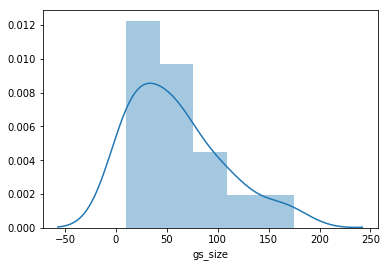

In [154]:
sns.distplot(df_assoc.gs_size)

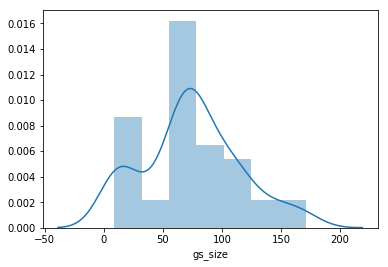

In [155]:
sns.distplot(df_infer.gs_size)

In [156]:
#add in the nonoverlap genes between assoc and infer, and append each table as an extra row
genes_infer = []
for n in df_infer.gs:
    for m in n:
        genes_infer.append(m)
genes_assoc = []
for n in df_assoc.gs:
    for m in n:
        genes_assoc.append(m)  

genes_overlap = set(genes_infer).intersection(set(genes_assoc))
genes_nonoverlap = (set(genes_infer)-genes_overlap).union(set(genes_assoc)-genes_overlap)

df = pd.DataFrame([{'gs':list(genes_nonoverlap),'gs_size':len(genes_nonoverlap)}])
df_assoc = pd.concat([df_assoc,df], ignore_index=True)
df_infer = pd.concat([df_infer,df], ignore_index=True)

In [157]:
# retrieve the genes L100
df_L100['gs'] = df_L100.genes.apply(lambda x: re.findall('(\w*)\.\.', x))
df_L100['gs'] = df_L100.apply(lambda x: re.findall('(\w*)\s', x['landmark'])+x['gs'], axis=1)
df_L100['gs_size'] = df_L100.apply(lambda x: len(x['gs']), axis=1)
df_L100.head()

,cluster,genes,size,landmark,gs,gs_size
0,1,"ABHD8..79575.,ACP5..54.,ACTL9..284382.,ADAMTS1...",224,TMEM167A (153339),"[TMEM167A, ABHD8, ACP5, ACTL9, ADAMTS10, AKAP8...",225
1,2,"AADAT..51166.,ABAT..18.,ACTL6B..51412.,ADHFE1....",226,CDC40 (51362),"[CDC40, AADAT, ABAT, ACTL6B, ADHFE1, AEBP2, AF...",227
2,3,"AASS..10157.,ADI1..55256.,ADO..84890.,AES..166...",261,PBRM1 (55193),"[PBRM1, AASS, ADI1, ADO, AES, AGXT, AGXT2, AIM...",262
3,4,"ACTR5..79913.,ADRM1..11047.,AICDA..57379.,ARID...",182,PDS5A (23244),"[PDS5A, ACTR5, ADRM1, AICDA, ARID1B, ARID3C, A...",183
4,5,"ABT1..29777.,ACD..65057.,ACTR8..93973.,AFF1..4...",173,SMARCE1 (6605),"[SMARCE1, ABT1, ACD, ACTR8, AFF1, AFF4, AIP, A...",174


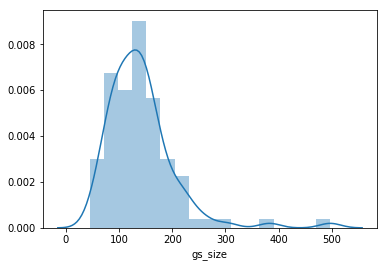

In [158]:
sns.distplot(df_L100.gs_size)

#### calculate multinomial probability, and entropy

In [159]:
from scipy.stats import multinomial

def calcOverlap(df_source, df_target):
    score = 1
    gs_target = df_target['gs']
    gs_target_sizes = df_target['gs_size']
    gs_source = df_source['gs']
    
    overlap_n = []
    for gs in gs_target:
        overlap_n.append( len(set(gs).intersection(set(gs_source))) )

    p = multinomial.pmf(overlap_n, n=sum(overlap_n), p = gs_target_sizes.values/gs_target_sizes.sum() )
    return p

pmfs_assoc = df_L100.apply(calcOverlap, df_target=df_assoc, axis=1)
pmfs_infer = df_L100.apply(calcOverlap, df_target=df_infer, axis=1)

In [167]:
df_pmfs = pd.DataFrame({'assoc': pmfs_assoc,
                        'infer': pmfs_infer,})

In [168]:
df_pmfs.describe()

,assoc,infer
count,1.000000e+02,1.000000e+02
mean,8.561705e-05,3.157775e-07
std,7.100060e-04,2.433996e-06
min,2.100165e-104,3.888555e-109
25%,1.506623e-18,9.910466e-20
50%,7.607040e-13,3.386116e-13
75%,2.345382e-10,1.318394e-10
max,6.929703e-03,2.408172e-05


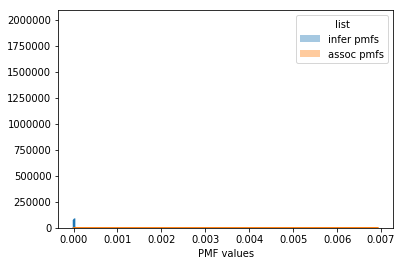

In [169]:
sns.distplot(df_pmfs.infer)
sns.distplot(df_pmfs.assoc)

plt.legend(title='list',loc='upper right', labels=['infer pmfs', 'assoc pmfs'])
plt.xlabel('PMF values')
plt.show()

In [170]:
pd.DataFrame([{'assoc':-np.sum(df_pmfs.assoc* np.log(df_pmfs.assoc)),
              'infer':-np.sum(df_pmfs.infer* np.log(df_pmfs.infer))}], index=['entropy'])

,assoc,infer
entropy,0.045028,0.000355


#### Calculate simply overlap counts

In [163]:
def calcOverlap(df_source, df_target):
    score = 1
    gs_target = df_target['gs']
    gs_target_sizes = df_target['gs_size']
    gs_source = df_source['gs']
    
    overlap_n = []
    for gs in gs_target:
        overlap_n.append( len(set(gs).intersection(set(gs_source))) )
        
    return overlap_n
        
overlapN_assoc = df_L100.apply(calcOverlap, df_target=df_assoc, axis=1)
overlapN_infer = df_L100.apply(calcOverlap, df_target=df_infer, axis=1)

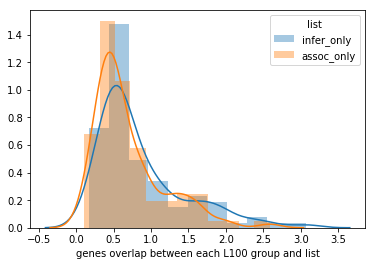

In [164]:
sns.distplot(overlapN_infer.apply(lambda x: np.mean(x)))
sns.distplot(overlapN_assoc.apply(lambda x: np.mean(x)))

plt.legend(title='list',loc='upper right', labels=['infer_only', 'assoc_only'])
plt.xlabel('genes overlap between each L100 group and list')
plt.show()

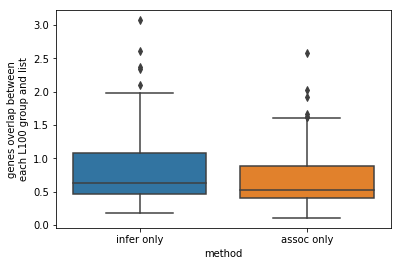

In [165]:
df1 = pd.DataFrame({'val':overlapN_infer.apply(lambda x: np.mean(x)), 'method':'infer only'})
df2 = pd.DataFrame({'val':overlapN_assoc.apply(lambda x: np.mean(x)), 'method':'assoc only'})
df = pd.concat([df1,df2])
sns.boxplot('method', 'val', data = df)
plt.ylabel('genes overlap between\neach L100 group and list')
plt.show()